Networks: ['BA', 'Cave_bottleneck', 'Cave_random', 'Complete', 'ER', 'RR', 'Stars', 'WS']
Dynamics: ['Choosing neighbor probability based on vertex degree q = 0.5', 'base model q = 0.5', 'both choosing neighbor probability and strength based on vertex degree', 'imitation strength based on vertex degree']
t range: 0 to 500
Columns: ['network', 'dynamic', 't', 'variance_mean', 'sem_total', 'sem_network', 'sem_runs']


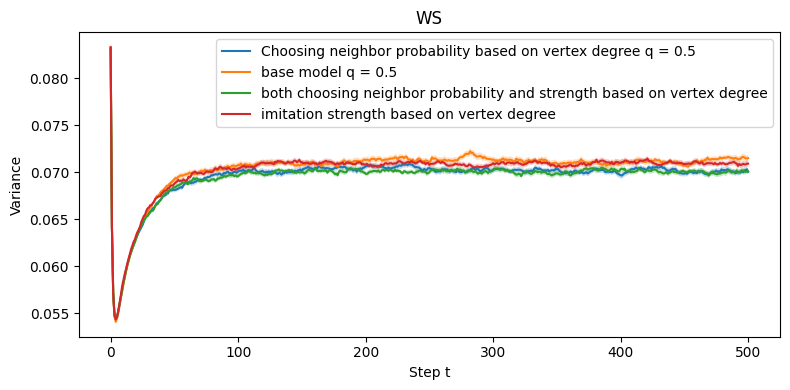

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from numba import njit
import pandas as pd
import math
import os
import time
from networkproperties import *
from creatingnetworks import *
from dynamicsfunctions import * 

path = r"C:\Users\sydmm\Desktop\thesisrefrence\thesiscodes\results\timeseries_variance.csv"
df = pd.read_csv(path)

print("Networks:", sorted(df["network"].unique()))
print("Dynamics:", sorted(df["dynamic"].unique()))
print("t range:", df["t"].min(), "to", df["t"].max())
print("Columns:", list(df.columns))

def plot_dynamics_for_network(df, network, dynamics=None, t0=0, t1=500, sem_kind="sem_total"):
    """
    Plot variance mean ± SEM for selected dynamics on one network over steps t0..t1.

    sem_kind:
      - "total" -> uses sem_total if present
      - "net"   -> uses sem_net   if present
      - "runs"  -> uses sem_runs  if present
      - if none of these exist, falls back to variance_sem (old format)
    """
    sem_map = {
        "total": "sem_total",
        "net":   "sem_net",
        "runs":  "sem_runs",
    }
    sem_col = sem_map.get(sem_kind, "variance_sem_total")


    if sem_col not in df.columns:
        if "variance_sem" in df.columns:
            sem_col = "variance_sem"
        else:
            raise ValueError(
                f"Requested sem_kind='{sem_kind}', but none of "
                f"{list(sem_map.values())} or 'variance_sem' exist in the CSV."
            )

    dfn = df[(df["network"] == network) & (df["t"].between(t0, t1))].copy()
    if dfn.empty:
        raise ValueError(f"No rows found for network={network} in steps {t0}..{t1}")

    if dynamics is None:
        dynamics = sorted(dfn["dynamic"].unique())
    else:
        dfn = dfn[dfn["dynamic"].isin(dynamics)]
        if dfn.empty:
            raise ValueError(f"None of the requested dynamics exist for network={network}")

    plt.figure(figsize=(8, 4), dpi=100)

    for dyn in dynamics:
        sub = dfn[dfn["dynamic"] == dyn].sort_values("t")
        t = sub["t"].to_numpy()
        m = sub["variance_mean"].to_numpy()
        s = sub[sem_col].to_numpy()

        plt.plot(t, m, label=dyn)
        plt.fill_between(t, m - s, m + s, alpha=0.25)

    plt.xlabel("Step t")
    plt.ylabel("Variance")
    plt.title(f"{network}")
    plt.legend()
    plt.tight_layout()
    plt.show()


plot_dynamics_for_network(df, network="WS", dynamics=None, t0=0, t1=500, sem_kind="total")




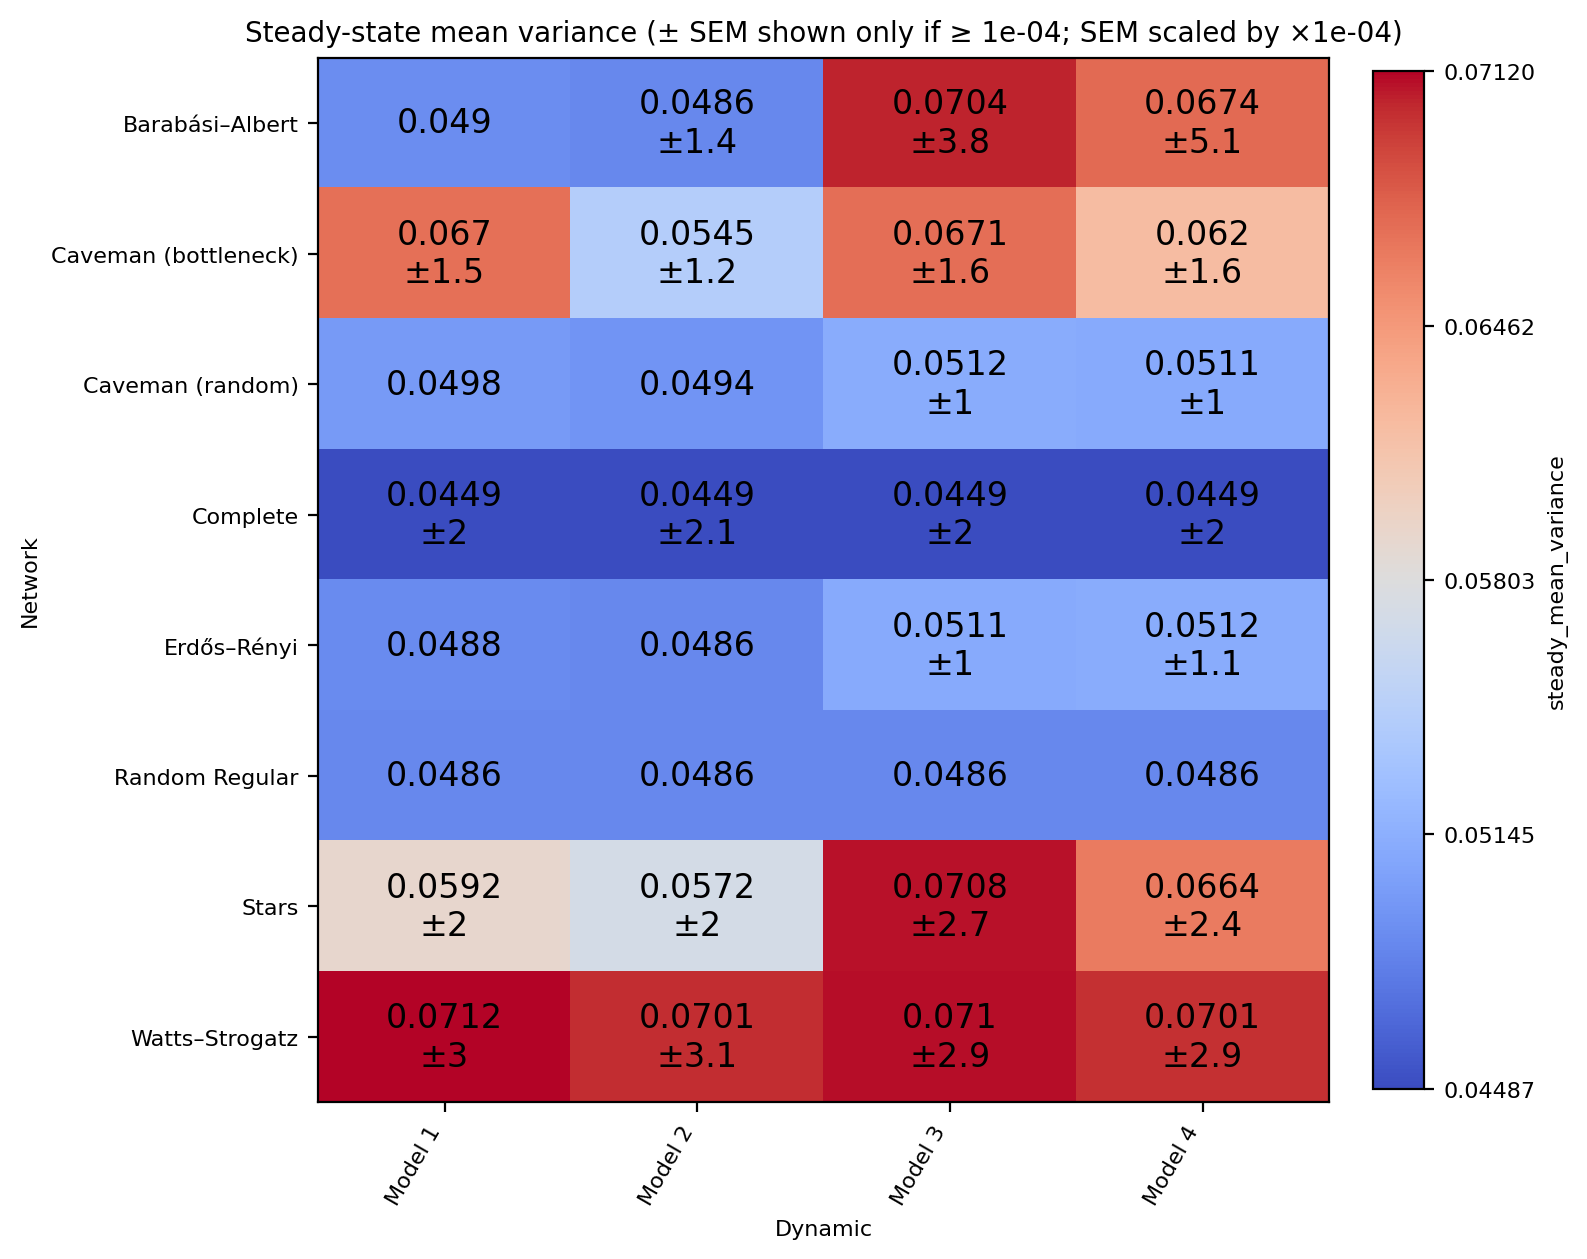

Matrix shape: (8, 4)
Networks: ['Barabási–Albert', 'Caveman (bottleneck)', 'Caveman (random)', 'Complete', 'Erdős–Rényi', 'Random Regular', 'Stars', 'Watts–Strogatz']
Dynamics: ['Model 1', 'Model 2', 'Model 3', 'Model 4']


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker


path = r"C:\Users\sydmm\Desktop\thesisrefrence\thesiscodes\results\steady_state_summary.csv"

value_col = "steady_mean_variance"
sem_col   = "steady_sem_total"  


dynamic_rename = {
    "base model q = 0.5": "Model 1",
    "Choosing neighbor probability based on vertex degree q = 0.5": "Model 2",
    "imitation strength based on vertex degree": "Model 3",
    "both choosing neighbor probability and strength based on vertex degree" : "Model 4",
}

network_rename = {"BA": "Barabási–Albert", "WS": "Watts–Strogatz",
     "ER": "Erdős–Rényi",  
     "Cave_bottleneck": "Caveman (bottleneck)",
     "Cave_random": "Caveman (random)",
     "RR": "Random Regular",
}

title_fs = 10
axis_fs  = 8
tick_fs  = 8
cell_fs  = 12

cmap_name = "coolwarm"          
cb_n_ticks = 5                
cb_step = None                

fig_w_per_col = 0.60
fig_h_per_row = 0.55

fmt_mean = "{:.3g}"
fmt_sem  = "{:.2g}"            
show_sem_in_cells = True      


df = pd.read_csv(path)

for c in ["network", "dynamic", value_col, sem_col]:
    if c not in df.columns:
        raise ValueError(f"Missing column '{c}'. Found: {list(df.columns)}")


df["dynamic_plot"] = df["dynamic"].map(dynamic_rename).fillna(df["dynamic"]).astype(str)
df["network_plot"] = df["network"].map(network_rename).fillna(df["network"]).astype(str)


heat = df.pivot_table(
    index="network_plot", columns="dynamic_plot", values=value_col, aggfunc="mean"
).sort_index()

heat_sem = df.pivot_table(
    index="network_plot", columns="dynamic_plot", values=sem_col, aggfunc="mean"
).reindex(index=heat.index, columns=heat.columns)

sem_vals = heat_sem.to_numpy()
max_sem = np.nanmax(sem_vals)

if np.isfinite(max_sem) and max_sem > 0:
    sem_order = 10.0 ** np.floor(np.log10(max_sem))  
else:
    sem_order = np.nan

sem_threshold = sem_order


fmt_mean = "{:.3g}"
fmt_sem_scaled = "{:.2g}"   


fig, ax = plt.subplots(
    figsize=(max(8, fig_w_per_col*heat.shape[1] + 3), max(5, fig_h_per_row*heat.shape[0] + 2)),
    dpi=200
)

im = ax.imshow(heat.to_numpy(), aspect="auto", interpolation="nearest", cmap=cmap_name)

ax.set_title(f"Steady-state mean variance (annotated with ± total variance SEM)" if show_sem_in_cells
             else "Steady-state mean variance",
             fontsize=title_fs)
ax.set_xlabel("Dynamic", fontsize=axis_fs)
ax.set_ylabel("Network", fontsize=axis_fs)

ax.set_xticks(np.arange(heat.shape[1]))
ax.set_xticklabels(heat.columns, rotation=60, ha="right", fontsize=tick_fs)
ax.set_yticks(np.arange(heat.shape[0]))
ax.set_yticklabels(heat.index, fontsize=tick_fs)


cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label(value_col, fontsize=axis_fs)
cbar.ax.tick_params(labelsize=tick_fs)

vmin, vmax = np.nanmin(heat.to_numpy()), np.nanmax(heat.to_numpy())

if cb_step is not None:

    ticks = np.arange(np.floor(vmin/cb_step)*cb_step, np.ceil(vmax/cb_step)*cb_step + cb_step/2, cb_step)
    cbar.set_ticks(ticks)
else:

    ticks = np.linspace(vmin, vmax, cb_n_ticks)
    cbar.set_ticks(ticks)


if show_sem_in_cells:
    data = heat.to_numpy()
    sems = heat_sem.to_numpy()

    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            if not np.isfinite(data[i, j]):
                continue

            txt = fmt_mean.format(data[i, j])

            if np.isfinite(sems[i, j]) and np.isfinite(sem_threshold):
                if sems[i, j] >= sem_threshold:
                    sem_scaled = sems[i, j] / sem_order
                    txt = f"{txt}\n±{fmt_sem_scaled.format(sem_scaled)}"

            ax.text(j, i, txt, ha="center", va="center", fontsize=cell_fs)

if np.isfinite(sem_order):
    ax.set_title(
        f"Steady-state mean variance (± SEM shown only if ≥ {sem_order:.0e}; SEM scaled by ×{sem_order:.0e})",
        fontsize=title_fs
    )
else:
    ax.set_title("Steady-state mean variance", fontsize=title_fs)

fig.tight_layout()
plt.show()

print("Matrix shape:", heat.shape)
print("Networks:", list(heat.index))
print("Dynamics:", list(heat.columns))
